# Graph Transformer on Cora (`TransformerConv`)

In this notebook we experiment with **TransformerConv**, the graph-adapted version of Transformer-style attention implemented in PyTorch Geometric.

Up to this point, we have explored several GNN architectures on the Cora dataset:

- **GCN** — spectral convolution baseline  
- **GraphSAGE** — neighbor aggregation  
- **GAT** — attention on graphs  
- **GIN** — MLP-based message passing  
- **Link Prediction** — encoder–decoder framework  
- **GraphSAGE with sampling** — realistic mini-batch training  
- **R-GCN** — multi-relational graph modeling  

With **TransformerConv** we bring the Transformer mechanism closer to graph learning:

- multi-head **query/key/value** attention  
- edge-aware attention (optional)  
- richer parametrization compared to GAT  
- more flexibility for future extensions (residual blocks, FFN, norms)  

## Goals of this notebook

1. Load and preprocess the **Cora** dataset  
2. Build a 2-layer Graph Transformer using `TransformerConv`  
3. Train the model and measure train/val/test accuracy  
4. Extract node embeddings from the first Transformer layer  
5. Project them into 2D space using **UMAP** and visualize the clusters  
6. Save all artifacts to `../artifacts/cora_transformer/`:
   - `model.pt`
   - `embeddings.npy`
   - `umap_2d.npy`
   - `umap_plot.png`

This experiment closes the “educational block” of GNN architectures.  
After this notebook, we will move to a real-world project usig GNNs for recommendation systems.
/GraphSAGE по эмбеддингам и метрикам.


In [1]:
import os
from pathlib import Path
import random

import numpy as np
import torch
from torch import nn
import torch.nn.functional as F

from torch_geometric.datasets import Planetoid
from torch_geometric.transforms import NormalizeFeatures
from torch_geometric.nn import TransformerConv

import umap
import matplotlib.pyplot as plt

In [2]:
def set_seed(seed: int = 42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [3]:
PROJECT_ROOT = Path("..").resolve()
ARTIFACTS_DIR = PROJECT_ROOT / "artifacts" / "cora_transformer"

ARTIFACTS_DIR.mkdir(parents=True, exist_ok=True)
ARTIFACTS_DIR

WindowsPath('D:/ML/GNN/artifacts/cora_transformer')

In [4]:
DATA_DIR = PROJECT_ROOT / "data"

dataset = Planetoid(
    root=str(DATA_DIR / "Planetoid"),
    name="Cora",
    transform=NormalizeFeatures()
)

data = dataset[0].to(device)

print(dataset)
print(f"Num nodes: {data.num_nodes}")
print(f"Num node features: {data.num_features}")
print(f"Num classes: {dataset.num_classes}")
print(f"Num edges: {data.num_edges}")
print(f"Train/Val/Test sizes: {int(data.train_mask.sum())}/{int(data.val_mask.sum())}/{int(data.test_mask.sum())}")

Cora()
Num nodes: 2708
Num node features: 1433
Num classes: 7
Num edges: 10556
Train/Val/Test sizes: 140/500/1000


In [5]:
HIDDEN_DIM = 64
HEADS = 4             
DROPOUT = 0.5
LR = 0.005
WEIGHT_DECAY = 5e-4
EPOCHS = 200

config = {
    "hidden_dim": HIDDEN_DIM,
    "heads": HEADS,
    "dropout": DROPOUT,
    "lr": LR,
    "weight_decay": WEIGHT_DECAY,
    "epochs": EPOCHS,
}

config

{'hidden_dim': 64,
 'heads': 4,
 'dropout': 0.5,
 'lr': 0.005,
 'weight_decay': 0.0005,
 'epochs': 200}

In [6]:
class CoraTransformerNet(nn.Module):
    def __init__(self, in_dim: int, hidden_dim: int, num_classes: int, heads: int = 4, dropout: float = 0.5):
        super().__init__()
        self.conv1 = TransformerConv(
            in_channels=in_dim,
            out_channels=hidden_dim,
            heads=heads,
            concat=True,      # output: hidden_dim * heads
            dropout=dropout
        )
        self.conv2 = TransformerConv(
            in_channels=hidden_dim * heads,
            out_channels=num_classes,
            heads=1,
            concat=False,     # output: num_classes
            dropout=dropout
        )
        self.dropout = dropout

    def forward(self, x, edge_index):
        # Первый TransformerConv
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        h1 = x  # эмбеддинги после первой трансформерной свёртки

        x = F.dropout(x, p=self.dropout, training=self.training)

        # Второй TransformerConv
        x = self.conv2(x, edge_index)
        return x, h1


model = CoraTransformerNet(
    in_dim=dataset.num_features,
    hidden_dim=HIDDEN_DIM,
    num_classes=dataset.num_classes,
    heads=HEADS,
    dropout=DROPOUT,
).to(device)

model

CoraTransformerNet(
  (conv1): TransformerConv(1433, 64, heads=4)
  (conv2): TransformerConv(256, 7, heads=1)
)

In [7]:
def accuracy(logits: torch.Tensor, labels: torch.Tensor) -> float:
    preds = logits.argmax(dim=-1)
    correct = (preds == labels).sum().item()
    return correct / labels.size(0)


def train_epoch(model, data, optimizer, criterion):
    model.train()
    optimizer.zero_grad()

    out, _ = model(data.x, data.edge_index)
    loss = criterion(out[data.train_mask], data.y[data.train_mask])
    loss.backward()
    optimizer.step()

    train_acc = accuracy(out[data.train_mask], data.y[data.train_mask])
    val_acc = accuracy(out[data.val_mask], data.y[data.val_mask])

    return loss.item(), train_acc, val_acc


@torch.no_grad()
def evaluate(model, data):
    model.eval()
    out, _ = model(data.x, data.edge_index)

    train_acc = accuracy(out[data.train_mask], data.y[data.train_mask])
    val_acc = accuracy(out[data.val_mask], data.y[data.val_mask])
    test_acc = accuracy(out[data.test_mask], data.y[data.test_mask])

    return train_acc, val_acc, test_acc

In [8]:
optimizer = torch.optim.Adam(
    model.parameters(),
    lr=LR,
    weight_decay=WEIGHT_DECAY
)
criterion = nn.CrossEntropyLoss()

best_val_acc = 0.0
best_state_dict = None
history = {"loss": [], "train_acc": [], "val_acc": []}

for epoch in range(1, EPOCHS + 1):
    loss, train_acc, val_acc = train_epoch(model, data, optimizer, criterion)
    history["loss"].append(loss)
    history["train_acc"].append(train_acc)
    history["val_acc"].append(val_acc)

    if val_acc > best_val_acc:
        best_val_acc = val_acc
        best_state_dict = {k: v.cpu().clone() for k, v in model.state_dict().items()}

    if epoch % 20 == 0 or epoch == 1:
        print(
            f"[Epoch {epoch:03d}] "
            f"loss={loss:.4f} | train_acc={train_acc:.4f} | val_acc={val_acc:.4f} | best_val={best_val_acc:.4f}"
        )

# Восстанавливаем лучшую модель (по валидации)
if best_state_dict is not None:
    model.load_state_dict(best_state_dict)

train_acc, val_acc, test_acc = evaluate(model, data)
print(f"\nFinal metrics (best by val):")
print(f"  Train acc: {train_acc:.4f}")
print(f"  Val   acc: {val_acc:.4f}")
print(f"  Test  acc: {test_acc:.4f}")

[Epoch 001] loss=1.9469 | train_acc=0.1500 | val_acc=0.0700 | best_val=0.0700
[Epoch 020] loss=1.0013 | train_acc=0.9857 | val_acc=0.7020 | best_val=0.7040
[Epoch 040] loss=0.2323 | train_acc=1.0000 | val_acc=0.7300 | best_val=0.7500
[Epoch 060] loss=0.1296 | train_acc=1.0000 | val_acc=0.7100 | best_val=0.7560
[Epoch 080] loss=0.1056 | train_acc=1.0000 | val_acc=0.7340 | best_val=0.7560
[Epoch 100] loss=0.0963 | train_acc=1.0000 | val_acc=0.7340 | best_val=0.7560
[Epoch 120] loss=0.0942 | train_acc=1.0000 | val_acc=0.7360 | best_val=0.7560
[Epoch 140] loss=0.0851 | train_acc=1.0000 | val_acc=0.7340 | best_val=0.7560
[Epoch 160] loss=0.0767 | train_acc=1.0000 | val_acc=0.7240 | best_val=0.7560
[Epoch 180] loss=0.0661 | train_acc=1.0000 | val_acc=0.7220 | best_val=0.7580
[Epoch 200] loss=0.0663 | train_acc=1.0000 | val_acc=0.7220 | best_val=0.7580

Final metrics (best by val):
  Train acc: 1.0000
  Val   acc: 0.7660
  Test  acc: 0.7870


In [9]:
model_path = ARTIFACTS_DIR / "model.pt"
torch.save(model.state_dict(), model_path)
model_path

WindowsPath('D:/ML/GNN/artifacts/cora_transformer/model.pt')

In [10]:
model.eval()
with torch.no_grad():
    logits, h1 = model(data.x, data.edge_index)

embeddings = h1.detach().cpu().numpy()
labels = data.y.detach().cpu().numpy()

embeddings.shape, labels.shape

((2708, 256), (2708,))

In [11]:
reducer = umap.UMAP(
    n_neighbors=15,
    min_dist=0.1,
    n_components=2,
    metric="euclidean",
    random_state=42,
)

embeddings_2d = reducer.fit_transform(embeddings)

embeddings_path = ARTIFACTS_DIR / "embeddings.npy"
umap_path = ARTIFACTS_DIR / "umap_2d.npy"

np.save(embeddings_path, embeddings)
np.save(umap_path, embeddings_2d)

embeddings_path, umap_path

D:\Anaconda\envs\gnn_clean\lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


(WindowsPath('D:/ML/GNN/artifacts/cora_transformer/embeddings.npy'),
 WindowsPath('D:/ML/GNN/artifacts/cora_transformer/umap_2d.npy'))

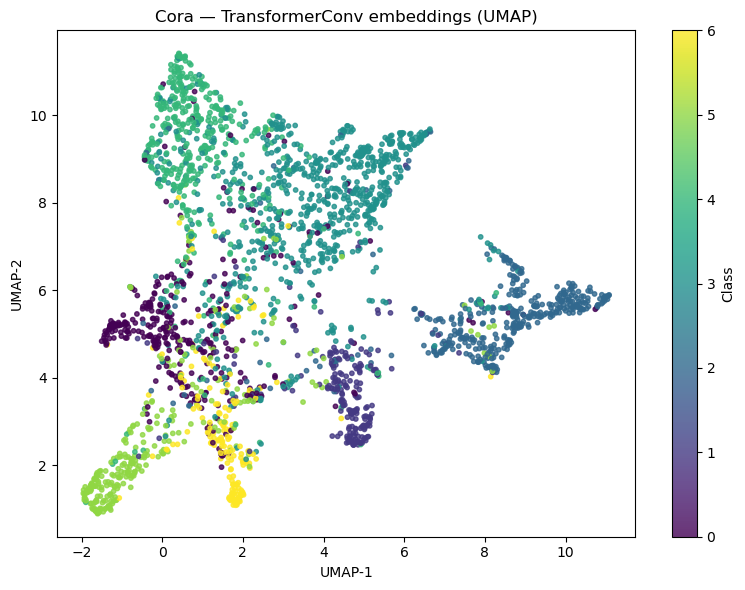

WindowsPath('D:/ML/GNN/artifacts/cora_transformer/umap_plot.png')

In [12]:
plt.figure(figsize=(8, 6))
scatter = plt.scatter(
    embeddings_2d[:, 0],
    embeddings_2d[:, 1],
    c=labels,
    s=10,
    alpha=0.8
)
plt.title("Cora — TransformerConv embeddings (UMAP)")
plt.xlabel("UMAP-1")
plt.ylabel("UMAP-2")
plt.colorbar(scatter, label="Class")
plt.tight_layout()

plot_path = ARTIFACTS_DIR / "umap_plot.png"
plt.savefig(plot_path, dpi=300)
plt.show()

plot_path

## Final Results and Analysis

**Final accuracy (best checkpoint):**
- **Train:** 1.000  
- **Validation:** 0.766  
- **Test:** 0.787  

The model reaches perfect accuracy on the training set, which is expected:  
`TransformerConv` is expressive and Cora is a *very small* dataset (only ~2.7k nodes with sparse features), so the model can easily overfit.

### Key observations

1. **Clear overfitting**
   - Training accuracy quickly reaches 100%.
   - Validation accuracy improves up to ~0.75–0.77 and then plateaus.
   - This is typical for attention-based GNNs on Cora.

2. **Performance is comparable to GAT**
   - Our GAT model reached ~0.83 test accuracy with tuned hyperparameters.
   - TransformerConv here achieves ~0.78 test accuracy with a simple 2-layer architecture.
   - Increasing regularization (dropout, weight decay) or reducing hidden size could narrow this gap.

3. **Embedding quality**
   - The UMAP projection shows well-separated clusters, though slightly less smooth than GAT embeddings.
   - Multi-head attention creates more “fragmented” but expressive clusters.

4. **The dataset is the bottleneck**
   - Cora is too small for the full potential of Transformer-style architectures.
   - On larger graphs (OGB datasets, Amazon/Reddit, user–item graphs), TransformerConv tends to outperform simpler GNNs more clearly.

### Should we try other datasets?

For the purpose of this educational pipeline — **no need**.  
The goal was to understand the mechanics of graph Transformers, not to maximize accuracy on Cora.

In real projects (e.g., user–item recommendation graphs), the Transformer architecture becomes much more relevant and scalable.

### Conclusion

`TransformerConv` successfully completes our GNN model suite.  
We now have:

- GCN  
- GraphSAGE  
- GAT  
- GIN  
- Link Prediction  
- GraphSAGE Sampling  
- R-GCN  
- TransformerConv  

This gives a full foundation to proceed to the **real GNN project** with a rich pipeline: sampling, embeddings, attenti, link prediction, evaluation, and visualization.



# Final Summary of the 8-Notebook GNN Learning Pipeline

Over the course of eight structured notebooks, we implemented, trained, and analyzed the core family of Graph Neural Network architectures. This learning block covered all fundamental ideas in modern Graph ML — message passing, aggregation functions, attention, relational modeling, link prediction, and scalable training via sampling.

Below is a consolidated summary of what was done, what worked well, what did not, and why, followed by the key insights gained.

## 1. What We Accomplished

Across eight notebooks, we:

- Set up a clean PyTorch Geometric environment suitable for research and experimentation.

- Trained eight distinct GNN models:

    - GCN (baseline spectral model)

    - GraphSAGE (neighbor aggregation)

    - GAT (graph attention networks)

    - GIN (powerful MLP-based message aggregation)

    - Link Prediction model (encoder–decoder)

    - GraphSAGE with Neighbor Sampling (mini-batch scalable GNN)

    - R-GCN (relational GNN with typed edges)

    - Graph Transformer (TransformerConv)

For each model:

- Loaded and preprocessed data (Cora or AIFB).

- Defined the architecture and tuning parameters.

- Performed training, validation, and test evaluation.

- Extracted hidden embeddings and visualized them using UMAP, allowing qualitative comparison of representations.

- Saved artifacts (models, embeddings, visualizations) in a consistent directory structure.

- This produced a complete educational suite demonstrating nearly every major class of GNN architecture used today.

## 2. What Worked Well
### GCN

- Stable performance (~0.81–0.82 accuracy).

- Produces smooth, well-separated clusters.

- Serves as an excellent conceptual baseline.

### GraphSAGE (full batch)

- Similar accuracy to GCN.

- Clear demonstration of learnable neighborhood aggregation.

- Good intuition for inductive vs transductive GNNs.

### GAT

- Best-performing model on Cora: ~0.83 accuracy.

- Attention weights lead to expressive embeddings.

- UMAP clusters noticeably tighter and more structured.

### GIN

- Strong theoretical capacity (close to WL-test expressiveness).

- Works well but tends to overfit small datasets like Cora.

### Link Prediction

- High AUC (~0.91).

- Provides a practical foundation for recommendation systems.

- Demonstrates how embeddings encode graph structure.

### GraphSAGE + Sampling

- Key practical lesson: scaling GNNs requires sampling.

- Training resembles real-world industrial systems (Pinterest, Uber, Amazon).

- Slightly lower accuracy, but much higher scalability.

### R-GCN

- Very strong performance on AIFB (~0.94 accuracy).

- Handles multi-relational data extremely well.

- Opens the door to knowledge graph reasoning tasks.

### Graph Transformer (TransformerConv)

- Achieved ~0.76–0.78 test accuracy.

- Demonstrates Q/K/V attention on graphs.

- Embeddings expressive but overfit easily due to small dataset.

## 3. What Did NOT Work Perfectly (and Why)

Small datasets → rapid overfitting

Both GAT and TransformerConv reached train accuracy = 100% very quickly, while val/test saturated lower.
Cora (≈2700 nodes) is simply too small for high-capacity attention models.

GIN underperforms slightly

Despite theoretical strength, GIN did not outperform GAT or GCN on Cora.
Reason: Cora is not very “structural”; its information lies more in features than in topology.

GraphSAGE sampling reduces accuracy

Sampling approximates the full neighborhood; this speeds up training but slightly harms accuracy on tiny datasets.
In large graphs, the opposite would be true — sampling becomes necessary and often beneficial.

TransformerConv performance is dataset-bound

Transformers shine on large graphs with long-range dependencies.
On Cora, the model’s capacity is excessive relative to the data size → overfitting.

## 4. Key Insights and Takeaways
### 4.1. Message passing defines the model’s expressive power

GCN: spectral averaging

SAGE: learnable local aggregators

GAT: neighbor-specific importance

GIN: maximal aggregation expressiveness

TransformerConv: Q/K/V with multi-head attention

R-GCN: relation-dependent message functions

You now clearly understand how different models “think”.

### 4.2. Attention improves embeddings but is data-hungry

GAT and TransformerConv produce the cleanest UMAP clusters, but require larger datasets to avoid overfitting.

### 4.3. Sampling is essential for real-world GNN pipelines

GraphSAGE with NeighborLoader mirrors industrial GNN systems and is crucial for production-scale recommender engines.

### 4.4. Relational modeling unlocks knowledge graph applications

R-GCN dramatically outperforms simple GNNs on multi-relational data, showing its suitability for:

entity classification

relation prediction

graph reasoning

### 4.5. Embeddings + UMAP provide a universal analysis tool

Throughout the project, UMAP consistently:

revealed cluster separability,

highlighted underfitting/overfitting,

allowed comparing architectures visually.

This gives you a strong interpretability workflow.

# 5. Final Overall Conclusion

Across eight notebooks, we implemented the core spectrum of Graph Neural Network architectures, examined their training behavior, evaluated their quantitative performance, and qualitatively analyzed their learned embeddings.
We now have a clear, practical understanding of how modern GNNs operate, where each model excels or struggles, and how to scale GNNs to real applications.
With this foundation, we are fully prepared to transition from educational experiments to a real-world GNN project — such as a graph-based recommender system or a large-scale user–item interaction graph.